In [1]:
import random
from lib2to3.pygram import pattern_symbols
from pathlib import Path
from tracemalloc import get_traceback_limit

In [1]:
from matplotlib import pyplot as plt

In [3]:
import monai
import numpy as np
import toml
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(155, 64, 64, 4)


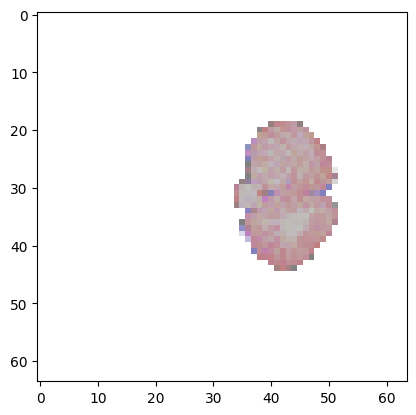

In [4]:
slices_array=np.load('/dhc/home/youngbin.ko/glow_brain/data/slices_train_new_64/BraTS20_Training_094_slices.npy')
print(slices_array.shape)
plt.imshow(slices_array[15,:, :, :])
plt.show()

In [2]:
import os
import matplotlib.pyplot as plt
import einops

In [78]:
class BratsDataset(Dataset):
    def __init__(self, paths, tfms=None):
        self.tfms = tfms # a list of transformations to be applied to the data
        self.paths = paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = np.load(path)
        # print(img.shape)
        # Display the merged image using Matplotlib
        # plt.imshow(img[2,:, :, 100], cmap='gray') # use first as channel (glow channel is third dim.) last one use as batch size by multiply with patient number.
        # plt.title(index)
        # plt.show()

        #img_2d = np.transpose(img, (3, 0, 1, 2))
        img = einops.rearrange(img, 'm h w s -> s h w m')
        print(img.shape)
        # plt.imshow(img[100,:, :, 2], cmap='gray')
        # plt.show()

        if self.tfms:
            img = self.tfms(img)
        #index = int(path.stem.split("_")[-1])
        return img, index

In [13]:
def get_train_tfms(seed=42):
    transforms = monai.transforms.Compose([
        monai.transforms.RandSpatialCropd(keys="img", roi_size=(120, 120, 120), random_size=True),
        #monai.transforms.Resized(keys="img", spatial_size=(128, 128, 128), mode=['area', 'nearest']),
        monai.transforms.Resized(keys="img", spatial_size=(128, 128, 128), mode='area'),
        monai.transforms.RandFlipd(keys="img", prob=0.5, spatial_axis=0),
        monai.transforms.RandFlipd(keys="img", prob=0.5, spatial_axis=1),
        monai.transforms.RandFlipd(keys="img", prob=0.5, spatial_axis=2),
        monai.transforms.RandAdjustContrastd(keys="img", prob=0.7, gamma=(0.5, 2.5)),
        monai.transforms.RandShiftIntensityd(keys="img", offsets=0.125, prob=0.7),
        monai.transforms.ToTensor(dtype=torch.float),
    ])
    transforms.set_random_state(seed)
    return transforms


def get_test_tfms(seed=42):
    transforms = monai.transforms.Compose([monai.transforms.ToTensor(dtype=torch.float)])
    transforms.set_random_state(seed)
    return transforms


def get_datasets(val_split=0.05, seed=42):
    brats_dir = Path('/dhc/home/youngbin.ko/glow_brain/data')

    train_paths = list((brats_dir / 'train').glob('*.npy'))
    train_dataset = BratsDataset(train_paths, get_train_tfms(seed=seed))
    valid_paths = list((brats_dir / 'val').glob('*.npy'))
    valid_dataset = BratsDataset(valid_paths, get_test_tfms(seed=seed))    

    return train_dataset, valid_dataset

In [79]:
train_dataset, valid_dataset = get_datasets()


In [57]:
data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [26]:
# to separate folders
import os
import random
import shutil

data_path = "/dhc/home/youngbin.ko/brain_data/data/val"
destination_path = "/dhc/home/youngbin.ko/brain_data/data/test"
num_folders = 15

subfolders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

random.seed(42)
selected_folders = random.sample(subfolders, num_folders)

for folder in selected_folders:
    src = os.path.join(data_path, folder)
    dst = os.path.join(destination_path, folder)
    shutil.move(src, dst)

(240, 240, 155)


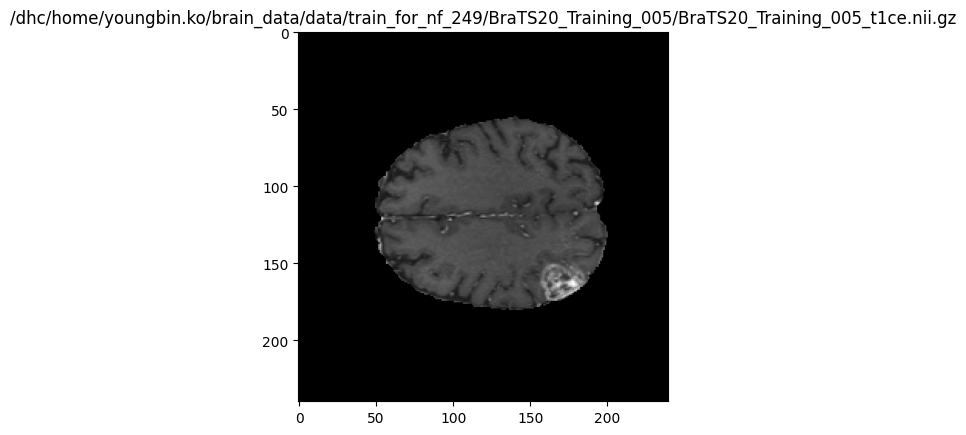

(240, 240, 155)


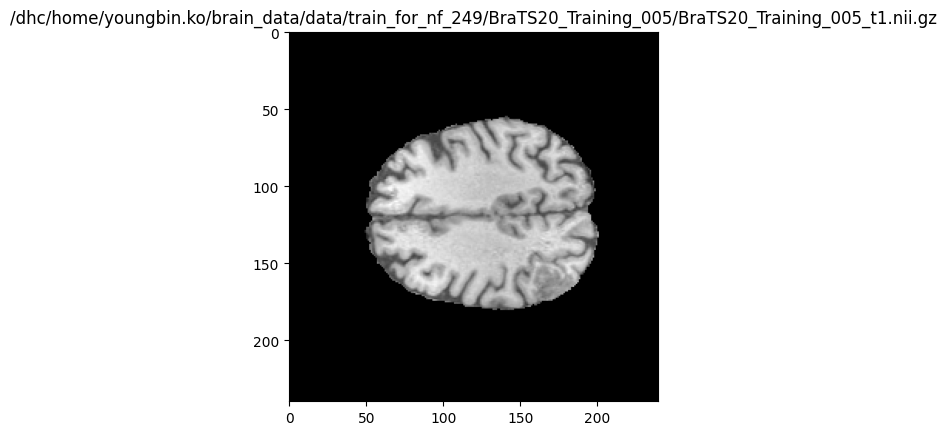

(240, 240, 155)


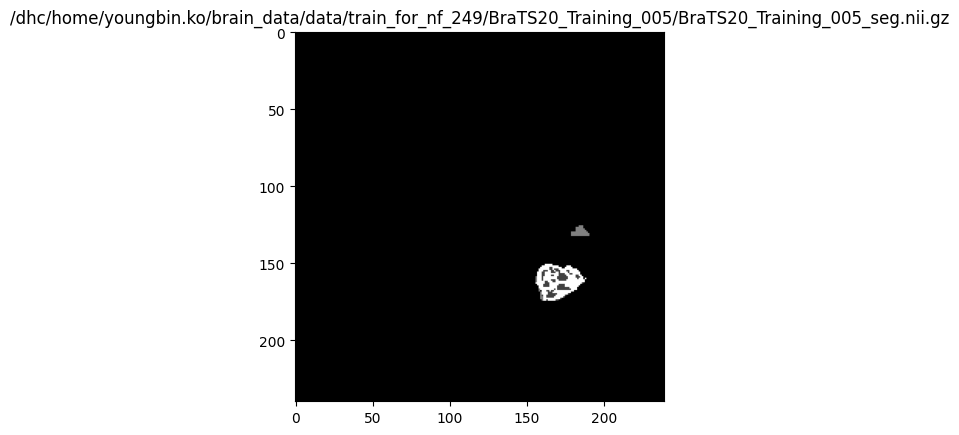

(240, 240, 155)


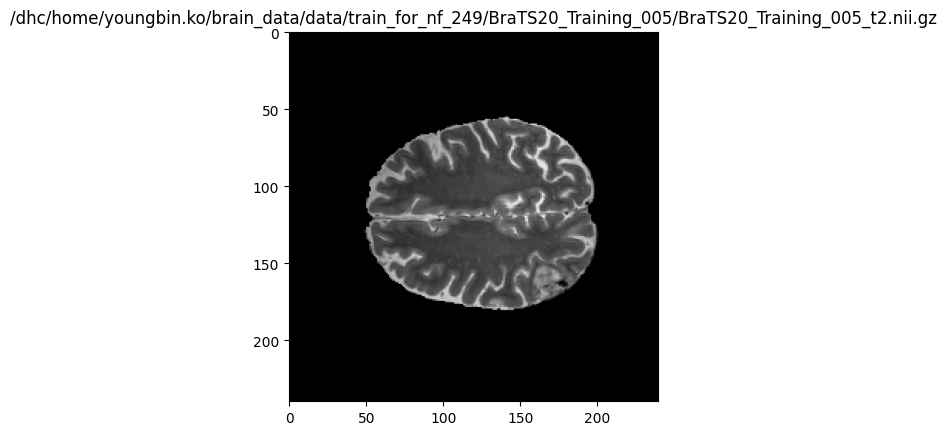

(240, 240, 155)


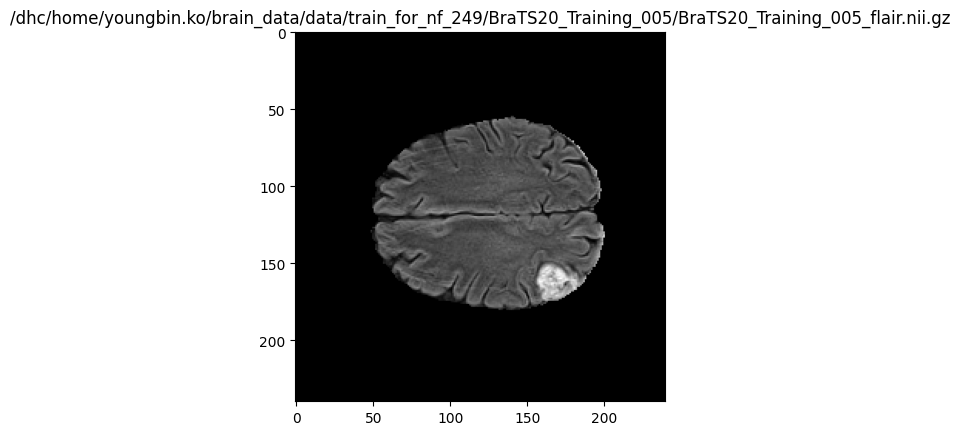

In [76]:
import glob
import nibabel as nib
import matplotlib.pyplot as plt

nii_files = glob.glob('/dhc/home/youngbin.ko/brain_data/data/train_for_nf_249/BraTS20_Training_005/*.nii.gz')
for file_path in nii_files:
    # Load the NIfTI file
    img = nib.load(file_path)
    print(img.shape)
    # Get the data from the NIfTI file
    data = img.get_fdata()

    # Display the image using Matplotlib
    plt.imshow(data[:, :, 100], cmap='gray')
    plt.title(file_path)
    plt.show()

(5, 240, 240, 155)


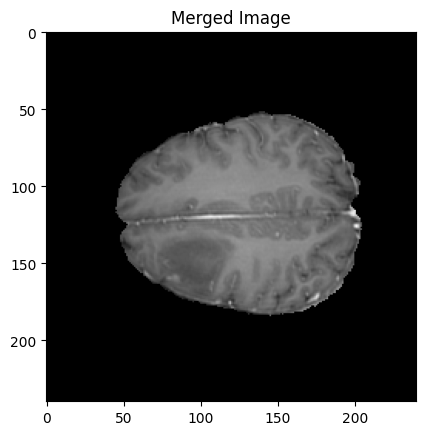

In [72]:
imgs = [nib.load(file_path).get_fdata() for file_path in nii_files]

# Merge the data from each NIfTI file into a single image
merged_img = np.stack(imgs)
print(merged_img.shape)
# Display the merged image using Matplotlib
plt.imshow(merged_img[2,:, :, 100], cmap='gray') # use first as channel (glow channel is third dim.) last one use as batch size by multiply with patient number.
plt.title("Merged Image")
plt.show()